# Explore differences between CEH-GEAR and HadUK-Grid
In this notebook we explore the differences between two gridded rainfall products over the UK.
Both datasets are in a 1km by 1km grid.

## Table of contents:
[1. Load data](#1-load-data)  
[2. Calc difference between dataset](#2-calculate-difference-between-haduk-to-ceh-gear)  
[3. Explore differences between datasets](#3-explore-differences-between-gridded-datasets)  
[4. Compare by Upper Severn catchments](#4-compare-datasets-by-upper-severn-catchments)  

In [1]:
import numpy as np
import polars as pl
import shapely.geometry
import geopandas as gpd
import xarray as xr
import rioxarray

import matplotlib.pyplot as plt
import scipy.stats

# utility functions required for this notebook
from utils import utils


In [2]:
RAIN_COL = "rain_mm"

EASTING_RANGE = [279000, 324000] ## based on data I have. Entire easting range is: [279000, 388000]
NORTHING_RANGE = [271000, 308000] ## based on data I have. Entire northing range is: [271000, 341000]

# 1. Load data
[Back to Index](#table-of-contents)

In [3]:
## Please see gridded_data for information on how to download 1km rainfall data
with open('../path_to_ceh_data.txt') as path:
    PATH_TO_CEHGEAR = path.read()

with open('../path_to_haduk_data.txt') as path:
    PATH_TO_HADUK = path.read()

## Load CEH-GEAR

In [4]:
ceh_severn = xr.open_dataset(f'{PATH_TO_CEHGEAR}/ceh_1km_severnregion_19700101_20230101.nc')
ceh_severn = ceh_severn.rename({'rainfall_amount': RAIN_COL})

ceh_abermule = ceh_severn.sel(x=slice(*EASTING_RANGE), y=slice(*NORTHING_RANGE))

## Load HadUK-Grid

In [5]:
haduk_severn = xr.open_mfdataset([f'{PATH_TO_HADUK}/haduk_grid_1km_day/hadukgrid_1km_abermuleregion_19700101_19860831.nc',\
                f'{PATH_TO_HADUK}/haduk_grid_1km_day/hadukgrid_1km_abermuleregion_19860901_20041231.nc',\
                 f'{PATH_TO_HADUK}/haduk_grid_1km_day/hadukgrid_1km_abermuleregion_20050101_20221231.nc'])
haduk_severn = haduk_severn.rename({'rainfall': RAIN_COL, 'projection_x_coordinate': 'x', 'projection_y_coordinate': 'y'})
haduk_severn = haduk_severn.drop_vars(('latitude', 'longitude'))
haduk_severn['time'] = haduk_severn['time'].dt.floor(freq='D')

haduk_abermule = haduk_severn.sel(x=slice(*EASTING_RANGE), y=slice(*NORTHING_RANGE))

## Load HGHT grid

In [6]:
severn_hght = rioxarray.open_rasterio('../catchment_boundaries/HGHT_SEVERN_1km.tif')
severn_hght = severn_hght.sortby('y')
severn_hght = severn_hght.sel(band=1)

severn_hght = severn_hght.sel(x=slice(*EASTING_RANGE), y=slice(*NORTHING_RANGE))

## Load gauge metadata

In [7]:
## monthly gauges
severn_monthly_gauges = pl.read_csv('../gauge_data/mo_monthly_gauges_severn.csv', try_parse_dates=True)

In [8]:
## Load gauge data (QC'd version)
severn_all_gauges = pl.read_csv('../gauge_data/mo_daily_severn_gauges.csv', try_parse_dates=True, new_columns=["gauge_id", "time", f'{RAIN_COL}_gauge', "mo_flag"])

In [9]:
# daily metadata
severn_metadata = pl.read_csv('../gauge_data/mo_severn_metadata.csv')

In [10]:
# Check for monthly only gauges in metadata
severn_metadata = severn_metadata.with_columns(
    (pl.col("ID").is_in(severn_monthly_gauges['ID']) & ~pl.col("ID").is_in(severn_all_gauges['gauge_id'].unique())).alias('IS_ONLY_MONTHLY_GAUGE')
)

severn_metadata = severn_metadata.with_columns(
    (~pl.col("ID").is_in(severn_monthly_gauges['ID']) & pl.col("ID").is_in(severn_all_gauges['gauge_id'].unique())).alias('IS_ONLY_DAILY_GAUGE')
)

print(severn_metadata['IS_ONLY_DAILY_GAUGE'].value_counts())
print(severn_metadata['IS_ONLY_MONTHLY_GAUGE'].value_counts())

shape: (2, 2)
┌─────────────────────┬───────┐
│ IS_ONLY_DAILY_GAUGE ┆ count │
│ ---                 ┆ ---   │
│ bool                ┆ u32   │
╞═════════════════════╪═══════╡
│ false               ┆ 296   │
│ true                ┆ 335   │
└─────────────────────┴───────┘
shape: (2, 2)
┌───────────────────────┬───────┐
│ IS_ONLY_MONTHLY_GAUGE ┆ count │
│ ---                   ┆ ---   │
│ bool                  ┆ u32   │
╞═══════════════════════╪═══════╡
│ false                 ┆ 612   │
│ true                  ┆ 19    │
└───────────────────────┴───────┘


## Load shapefiles

In [11]:
abermule_shp = gpd.read_file('../catchment_boundaries/Abermule/54014/54014.shp')
dolwen_shp = gpd.read_file('../catchment_boundaries/Dolwen/54080/54080.shp')
plynlimon_shp = gpd.read_file('../catchment_boundaries/Plynlimon Flume/54022/54022.shp')

## Mask height profile to catchments

In [12]:
def mask_region_rainfall(rainfall_data, region_mask):
    return rainfall_data * utils.binarize_hght_clip(region_mask).data


def mask_region_rainfall_by_hght(rainfall_data, region_hght, threshold):
    region_hght_mask = region_hght/region_hght.where(region_hght > threshold)
    return rainfall_data * region_hght_mask.data



In [13]:
abermule_hght = utils.make_region_hght_clip(abermule_shp, hght_data=severn_hght)
dolwen_hght = utils.make_region_hght_clip(dolwen_shp, hght_data=severn_hght)
plynlimon_hght = utils.make_region_hght_clip(plynlimon_shp, hght_data=severn_hght)


# 2. Calculate difference between HadUK to CEH-GEAR
[Back to Index](#table-of-contents)

## Shift grid
Because the two gridded datasets are on a different grid, we need to shift CEH-GEAR 500 metres in the X and Y dimension

In [14]:
def coerse_data_into_haduk_format(data, offset, xrange, yrange):
    """
    Quick fix for coersing data to have same grid as HADUK.
    """
    data = data.assign_coords(x=(data['x'] + offset))
    data = data.assign_coords(y=(data['y'] + offset))
    data = data.sel(x=xrange, y=yrange)
    return data

In [15]:
ceh_abermule_shifted = coerse_data_into_haduk_format(ceh_abermule, offset=500, xrange=slice(*EASTING_RANGE), yrange=slice(*NORTHING_RANGE))

In [16]:
ceh_abermule_shifted['hght'] = severn_hght

In [17]:
ceh_abermule_shifted = ceh_abermule_shifted.sel(time=slice(haduk_abermule['time'].min(), haduk_abermule['time'].max()))

In [18]:
ceh_haduk_diff = ceh_abermule_shifted[RAIN_COL] - haduk_abermule[RAIN_COL]
diff_col_name = f'{RAIN_COL}_diff'
ceh_haduk_diff = ceh_haduk_diff.to_dataset(name=diff_col_name)
ceh_haduk_diff['hght'] = severn_hght
ceh_haduk_diff['min_dist'] = ceh_abermule_shifted['min_dist']

In [19]:
ceh_haduk_diff.load()

<xarray.Dataset> Size: 516MB
Dimensions:       (time: 19358, x: 45, y: 37)
Coordinates:
  * time          (time) datetime64[ns] 155kB 1970-01-01 ... 2022-12-31
  * x             (x) float64 360B 2.795e+05 2.805e+05 ... 3.225e+05 3.235e+05
  * y             (y) float64 296B 2.715e+05 2.725e+05 ... 3.065e+05 3.075e+05
    band          int64 8B 1
    spatial_ref   int64 8B 0
Data variables:
    rain_mm_diff  (time, y, x) float64 258MB -0.131 0.7493 ... 0.7603 0.08435
    hght          (y, x) int32 7kB 5496 5237 5032 5012 ... 1677 1080 787 697
    min_dist      (time, y, x) float64 258MB 4.269e+03 4.756e+03 ... 513.4

In [20]:
ceh_haduk_diff[diff_col_name].min(), ceh_haduk_diff[diff_col_name].max()

(<xarray.DataArray 'rain_mm_diff' ()> Size: 8B
 array(-65.64007871)
 Coordinates:
     band         int64 8B 1
     spatial_ref  int64 8B 0,
 <xarray.DataArray 'rain_mm_diff' ()> Size: 8B
 array(75.51704562)
 Coordinates:
     band         int64 8B 1
     spatial_ref  int64 8B 0)

In [21]:
catchments_shp_and_hght = {'Abermule': {'shp': abermule_shp, 'hght': abermule_hght}, \
    'Dolwen': {'shp': dolwen_shp, 'hght': dolwen_hght},\
    'Plynlimon Flume': {'shp': plynlimon_shp, 'hght': plynlimon_hght}}

Text(0.5, 0.98, 'CEH-GEAR vs HadUK-Grid')

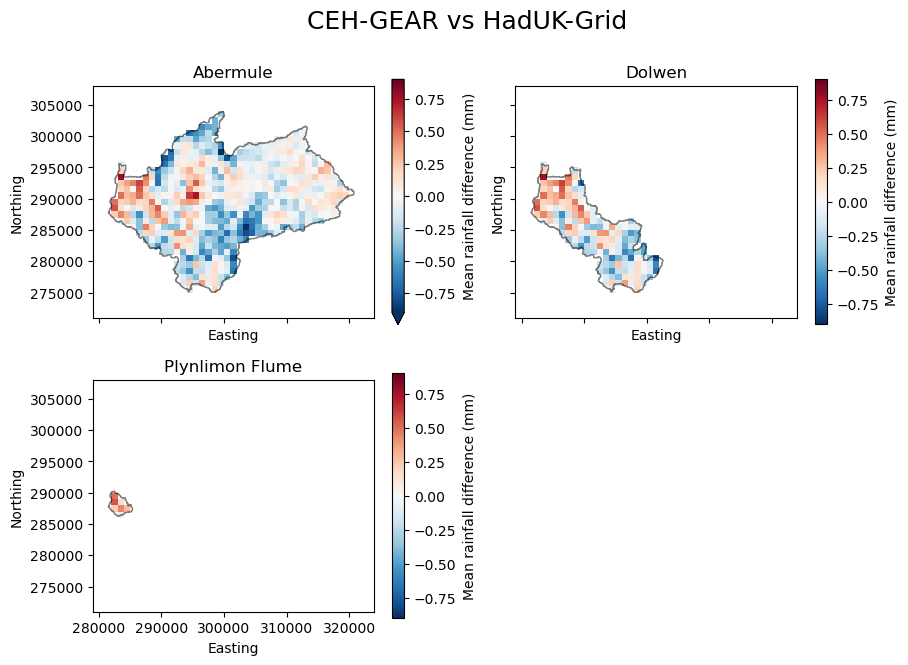

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)

for ax, catchment in zip(axes.flatten(), catchments_shp_and_hght.keys()):
    mask_region_rainfall(ceh_haduk_diff, catchments_shp_and_hght[catchment]['hght']).mean('time')[f'{RAIN_COL}_diff'].plot(ax=ax, vmin=-0.9, vmax=0.9, cmap='RdBu_r', cbar_kwargs={'label': 'Mean rainfall difference (mm)'})
    catchments_shp_and_hght[catchment]['shp'].plot(ax=ax, facecolor='none', alpha=.5)
    ax.set_title(f"{catchment}")
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
axes[1][1].remove()
fig.suptitle("CEH-GEAR vs HadUK-Grid", size=18)
# fig.savefig('../figures/ceh_vs_haduk_differences/catchment_mask_vs_boundary.png', bbox_inches='tight', dpi=200)

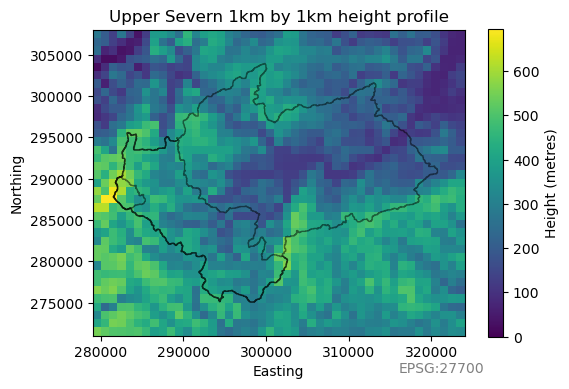

In [23]:
fig, ax = plt.subplots(1, figsize=(6, 4))
(ceh_abermule_shifted['hght']/10).plot(ax=ax, vmin=0, cbar_kwargs={'label': 'Height (metres)'})
abermule_shp.plot(ax=ax, facecolor='none', alpha=.5)
dolwen_shp.plot(ax=ax, facecolor='none', alpha=.5)
plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5)
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.set_title("Upper Severn 1km by 1km height profile")
ax.text(s="EPSG:27700", x=316000, y=266500, color='grey');

# fig.savefig('../figures/abermule_height_profile.png', bbox_inches='tight', dpi=200)

# 3. Explore differences between gridded datasets
[Back to Index](#table-of-contents)

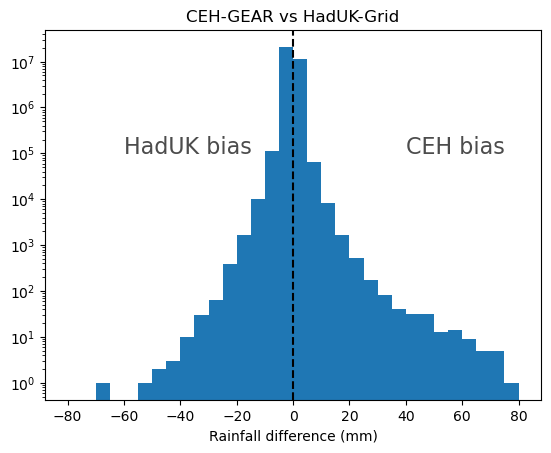

In [24]:
fig, ax = plt.subplots(1)
ceh_haduk_diff[diff_col_name].plot(ax=ax, bins=np.arange(-80, 81, 5))
ax.set_yscale('log')
ax.set_title("CEH-GEAR vs HadUK-Grid")
ax.set_xlabel("Rainfall difference (mm)")
ax.text(s="CEH bias", x=40, y=100000, color='k', alpha=.7, size=16)
ax.text(s="HadUK bias", x=-60, y=100000, color='k', alpha=.7, size=16)
ax.axvline(0, linestyle='--', color='k')

### ⭐ Intepretation of above figure:
-

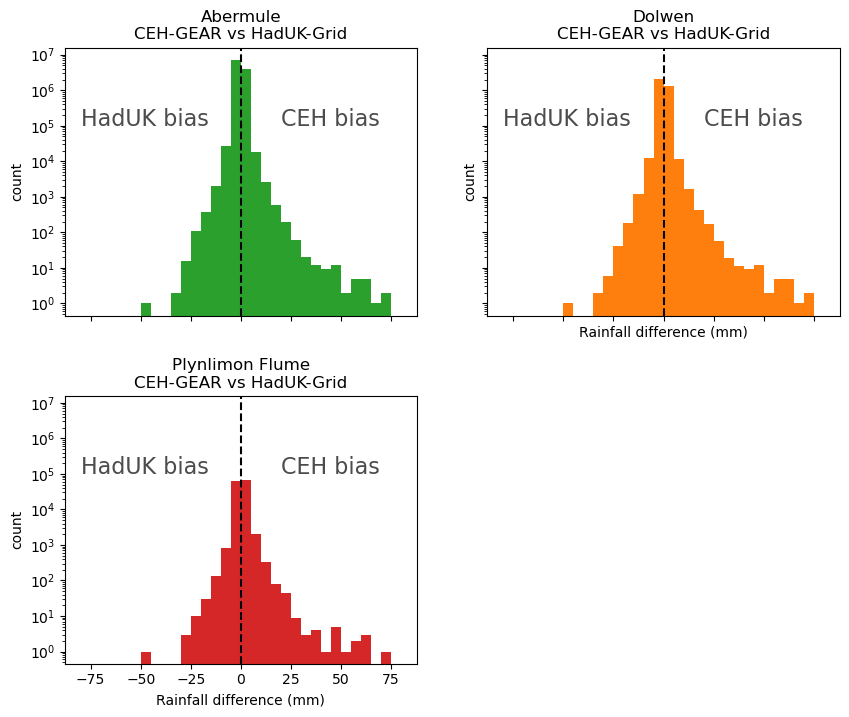

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

for ax, catchment, color_to_use in zip(axes.flatten(), catchments_shp_and_hght.keys(), ['C2', 'C1', 'C3']):
    region_mask_rainfall = mask_region_rainfall(ceh_haduk_diff, catchments_shp_and_hght[catchment]['hght'])
    region_mask_rainfall[diff_col_name].plot(ax=ax, color=color_to_use, bins=np.arange(-80, 81, 5))
    ax.set_yscale('log')
    ax.set_title(f"{catchment}\nCEH-GEAR vs HadUK-Grid")
    ax.set_xlabel("Rainfall difference (mm)")
    ax.set_ylabel('count')
    ax.text(s="CEH bias", x=20, y=100000, color='k', alpha=.7, size=16)
    ax.text(s="HadUK bias", x=-80, y=100000, color='k', alpha=.7, size=16)
    ax.axvline(0, linestyle='--', color='k')

axes[0][0].set_xlabel('')
axes[1][1].remove()
fig.subplots_adjust(hspace=.3)
# fig.savefig('../figures/ceh_vs_haduk_differences/catchment_hist_ceh_vs_haduk.png', bbox_inches='tight', dpi=200)

### ⭐ Intepretation of above figure:
-

### Annual mean

In [26]:
annual_ceh_haduk_diff = ceh_haduk_diff.groupby('time.year').mean()

Text(0.5, 1.0, 'Annual mean')

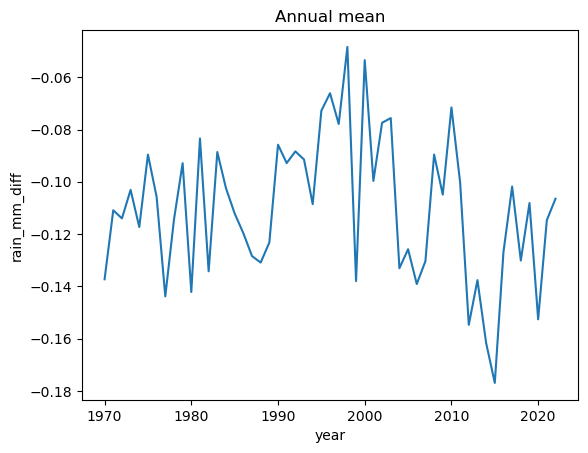

In [27]:
fig, ax = plt.subplots(1)
annual_ceh_haduk_diff[diff_col_name].mean(('x', 'y')).plot(ax=ax)
ax.set_title('Annual mean')

### by season

In [28]:
seasonal_ceh_haduk_diff = ceh_haduk_diff.groupby('time.season').mean()

In [29]:
abermule_mask_seasonal_rainfall = mask_region_rainfall(seasonal_ceh_haduk_diff, abermule_hght)


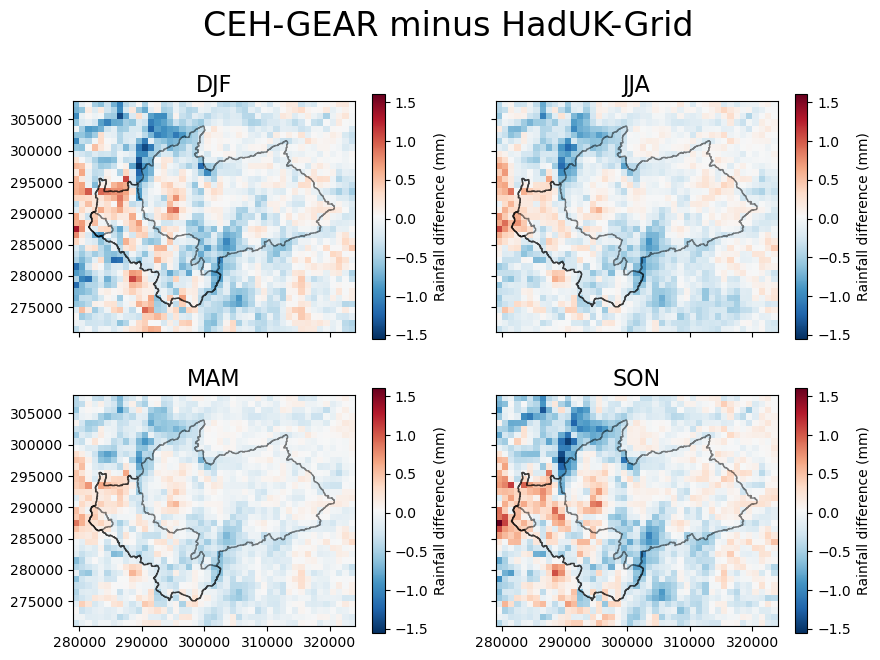

In [62]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)

for season, ax in zip(seasonal_ceh_haduk_diff['season'], axes.flatten()):
    seasonal_ceh_haduk_diff[diff_col_name].sel(season=season).plot(ax=ax, vmin=seasonal_ceh_haduk_diff[diff_col_name].min(), vmax=seasonal_ceh_haduk_diff[diff_col_name].max(),\
        cmap='RdBu_r', cbar_kwargs={'label':'Rainfall difference (mm)'})
    plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5)
    abermule_shp.plot(ax=ax, facecolor='none', alpha=.5)
    dolwen_shp.plot(ax=ax, facecolor='none', alpha=.5)
    ax.set_title(str(season.data), size=16)
    ax.set_xlabel(''); ax.set_ylabel('')
fig.suptitle('CEH-GEAR minus HadUK-Grid', size=24, y=1)
# fig.savefig('../figures/ceh_vs_haduk_differences/ceh_vs_haduk_by_season.png', bbox_inches='tight', dpi=200)

### ⭐ Intepretation of above figure:
-

### by month

In [31]:
monthly_ceh_haduk_diff = ceh_haduk_diff.groupby('time.month').mean()

Text(0.5, 1.0, 'Monthly mean')

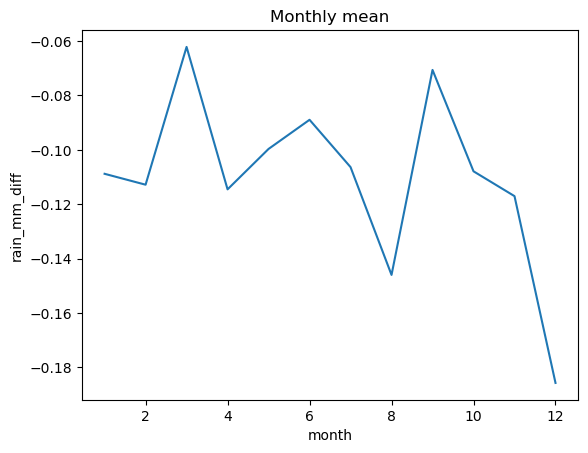

In [32]:
fig, ax = plt.subplots(1)
monthly_ceh_haduk_diff[diff_col_name].mean(('x', 'y')).plot(ax=ax)
ax.set_title('Monthly mean')

## by decade

In [33]:
ceh_haduk_diff = ceh_haduk_diff.assign_coords(decade=(ceh_haduk_diff.time.dt.year // 10) * 10)
decadal_ceh_haduk_diff = ceh_haduk_diff.groupby("decade").mean()

Text(0.5, 1.0, '')

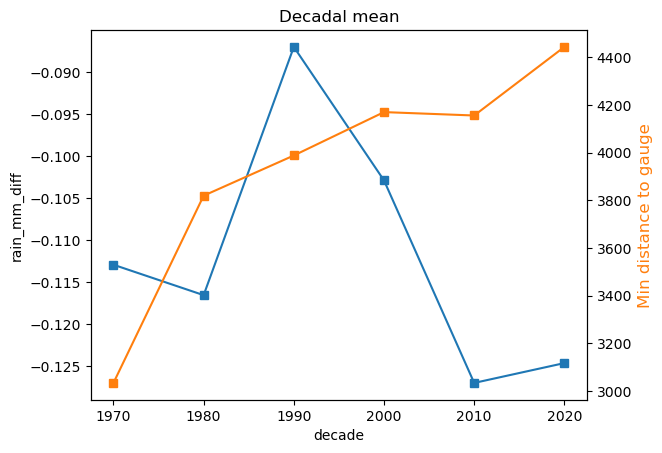

In [34]:
fig, ax = plt.subplots(1)
decadal_ceh_haduk_diff[diff_col_name].mean(('x', 'y')).plot(marker='s', ax=ax)
ax2 = ax.twinx()
decadal_ceh_haduk_diff['min_dist'].mean(('x', 'y')).plot(marker='s', ax=ax2, color='C1')
ax2.set_ylabel("Min distance to gauge", color='C1', size=12)
ax.set_title('Decadal mean')
ax2.set_title('')

### ⭐ Intepretation of above figure:
-

# 4. Compare datasets by Upper Severn catchments
[Back to Index](#table-of-contents)

In [35]:
ceh_haduk_diff_mean = ceh_haduk_diff.mean('time')

In [83]:
def plot_scatter_w_regline(x, y, ax, x_pos, y_pos, **kwargs):
    linreg_coef = np.polyfit(x, y, deg=1)
    linreg_func = np.poly1d(linreg_coef)
    rval, pval = scipy.stats.pearsonr(x, y)
    ax.scatter(x, y)
    ax.plot(x, y, 'o', x, linreg_func(x), **kwargs)
    ax.text(s=f'r={rval: .2f}\np={pval: .2f}', x=x_pos, y=y_pos)
    return ax


def plot_quadrat_count_plot(x, y, ax,  num_quadrats=6):
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    y_max = max(y_max, abs(y_min))
    x_bins = np.linspace(x_min, x_max, num_quadrats + 1)
    y_bins = np.linspace(-y_max, y_max, num_quadrats + 1)

    # Count points in each quadrat
    quadrat_counts = np.zeros((num_quadrats, num_quadrats))
    for i in range(num_quadrats):
        for j in range(num_quadrats):
            in_x_range = (x >= x_bins[i]) & (x < x_bins[i+1])
            in_y_range = (y >= y_bins[j]) & (y < y_bins[j+1])
            quadrat_counts[i, j] = np.sum(in_x_range & in_y_range)

    for x_bin in x_bins:
        ax.axvline(x_bin, color='gray', linestyle='--', alpha=0.6)
    for y_bin in y_bins:
        ax.axhline(y_bin, color='gray', linestyle='--', alpha=0.6)

    # Annotate quadrat counts
    for i in range(num_quadrats):
        for j in range(num_quadrats):
            ax.text((x_bins[i] + x_bins[i+1]) / 2,
                    (y_bins[j] + y_bins[j+1]) / 2,
                    int(quadrat_counts[i, j]),
                    color='red', fontsize=12, ha='center', va='center')

    return ax

### Time series

In [37]:
number_of_gauges_per_year = severn_all_gauges.sort('time').group_by_dynamic('time', every='1y').agg(pl.col("gauge_id").n_unique().alias('num_gauges'))

In [38]:
number_of_gauges_per_year.tail()

time,num_gauges
datetime[μs],u32
2020-01-01 00:00:00,92
2021-01-01 00:00:00,90
2022-01-01 00:00:00,84
2023-01-01 00:00:00,85
2024-01-01 00:00:00,87


<Axes: xlabel='time'>

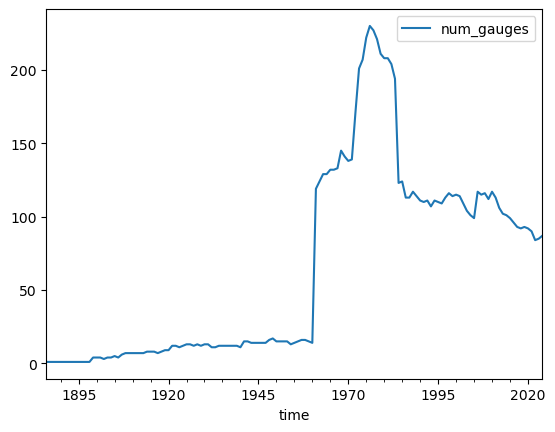

In [39]:
number_of_gauges_per_year.to_pandas().set_index('time').plot()

In [40]:
severn_metadata_geom = severn_metadata.with_columns(
    pl.struct('EASTING', 'NORTHING')
    .map_elements(lambda row: shapely.geometry.Point(row.values()), return_dtype=pl.Object)
    .alias('geometry')
)

severn_metadata_geom = gpd.GeoDataFrame(severn_metadata_geom.to_pandas(), crs='EPSG:27700')

In [41]:
def filter_gauge_data_by_catchment(catchment_name):
    region_shp_gauges = gpd.sjoin(catchments_shp_and_hght[catchment_name]['shp'], severn_metadata_geom, rsuffix='gauge', lsuffix='shp')
    region_gauges = severn_all_gauges.filter(pl.col('gauge_id').is_in(region_shp_gauges['ID_gauge'].values))
    return region_gauges

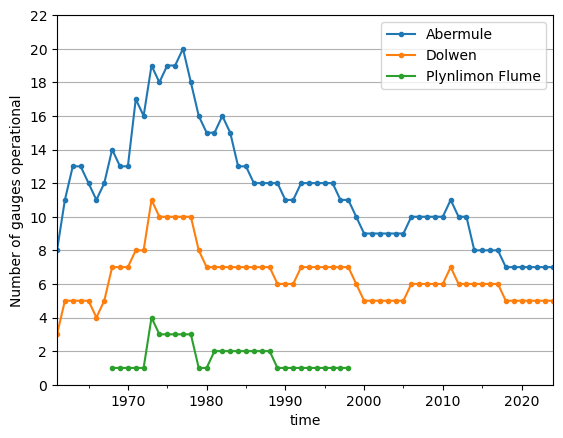

In [42]:
fig, ax = plt.subplots(1)
for region in catchments_shp_and_hght.keys():
    region_gauges = filter_gauge_data_by_catchment(region)
    region_number_of_gauges_per_year = region_gauges.sort('time').group_by_dynamic('time', every='1y').agg(pl.col("gauge_id").n_unique().alias(region))
    region_number_of_gauges_per_year = region_number_of_gauges_per_year.to_pandas().set_index('time')
    region_number_of_gauges_per_year.plot(ax=ax, marker='o', markersize=3)
ax.set_ylabel("Number of gauges operational")
ax.set_ylim(0, 22)
ax.set_yticks(np.arange(0, 23, 2));
ax.grid(axis='y')

C:\Users\tomkee\AppData\Local\Temp\ipykernel_16580\2992297351.py:21: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  region_number_of_gauges_per_year_xr = xr.Dataset(region_number_of_gauges_per_year)[catchment];
C:\Users\tomkee\AppData\Local\Temp\ipykernel_16580\2992297351.py:21: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.t

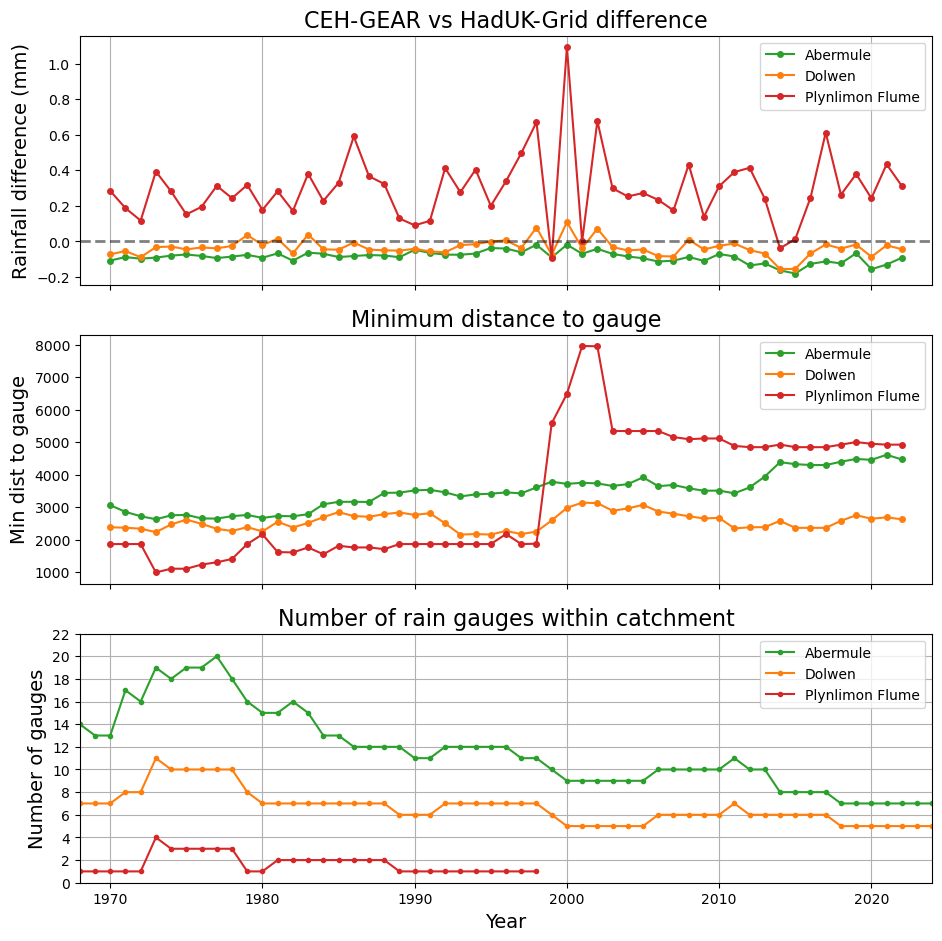

In [43]:
fig, axes = plt.subplots(3, 1, figsize=(11, 11), sharex=True)

## Plynlimon Flume will throw the yaxis, so you can remove it by setting with_plynlimon to False
with_plynlimon = True
with_plyn_label = ''

for catchment, color_to_use in  zip(catchments_shp_and_hght.keys(), ['C2', 'C1', 'C3']):
    if not with_plynlimon and catchment == 'Plynlimon Flume':
        with_plyn_label = '_wo_plyn'
        continue
    region_mask_diff = mask_region_rainfall(ceh_haduk_diff, catchments_shp_and_hght[catchment]['hght'])
    region_mask_diff_spatial_mean = region_mask_diff.mean(('x', 'y'))
    region_mask_diff_annual_mean = region_mask_diff_spatial_mean.groupby('time.year').mean()
    region_mask_diff_annual_mean['rain_mm_diff'].plot(ax=axes[0], c=color_to_use, marker='o', markersize=4)
    region_mask_diff_annual_mean['min_dist'].plot(ax=axes[1], c=color_to_use, marker='o', markersize=4)

    # number of gauges
    region_gauges = filter_gauge_data_by_catchment(catchment)
    region_number_of_gauges_per_year = region_gauges.sort('time').group_by_dynamic('time', every='1y').agg(pl.col("gauge_id").n_unique().alias(catchment))
    region_number_of_gauges_per_year = region_number_of_gauges_per_year.to_pandas().set_index('time')
    region_number_of_gauges_per_year_xr = xr.Dataset(region_number_of_gauges_per_year)[catchment];
    region_number_of_gauges_per_year_xr = region_number_of_gauges_per_year_xr.groupby('time.year').first()
    region_number_of_gauges_per_year_xr.plot(ax=axes[2], marker='o', markersize=3, c=color_to_use)

for ax in axes:
    ax.legend(catchments_shp_and_hght.keys())
    ax.grid(axis='x')
    ax.set_xlabel('')
axes[0].set_title("CEH-GEAR vs HadUK-Grid difference", size=16)
axes[1].set_title("Minimum distance to gauge", size=16)
axes[2].set_title("Number of rain gauges within catchment", size=16)
axes[2].set_xlabel('Year', size=14)
axes[0].set_ylabel("Rainfall difference (mm)", size=14)
axes[1].set_ylabel("Min dist to gauge", size=14)
axes[2].set_ylabel("Number of gauges", size=14)
axes[2].set_xlim(1968, 2024)
axes[2].set_ylim(0, 22)
axes[2].set_yticks(np.arange(0, 23, 2))
axes[2].grid(axis='y')

axes[0].axhline(0, linestyle='--', linewidth=2, color='k', alpha=.5)

# fig.savefig(f'../figures/ceh_vs_haduk_differences/ceh_vs_haduk_thru_time{with_plyn_label}.png', bbox_inches='tight', dpi=200)

### ⭐ Intepretation of above figure:
-

### Scatterplots

In [65]:
region_to_examine = 'Abermule'
region_diff = mask_region_rainfall(ceh_haduk_diff, catchments_shp_and_hght[region_to_examine]['hght'])
region_diff_mean = region_diff.mean('time')

Text(0.5, 0.98, 'CEH-GEAR vs HadUK Grid rainfall vs gauge height')

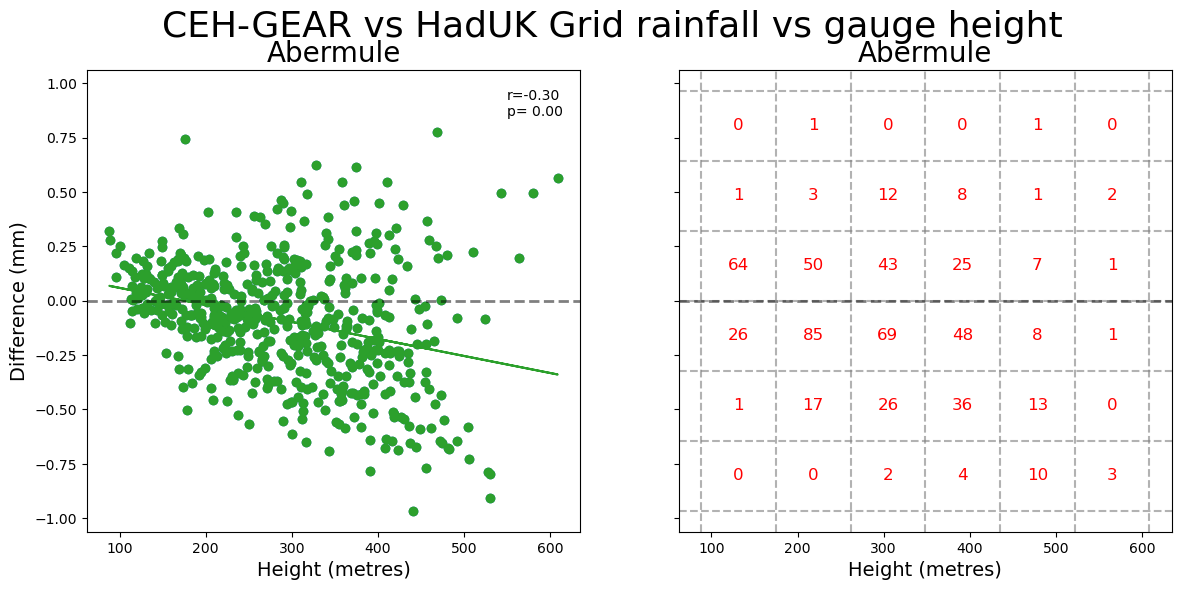

In [86]:
x = (region_diff_mean['hght']/10).data.flatten()
y = region_diff_mean['rain_mm_diff'].data.flatten()

## workaround required when using mask
x = x[np.isfinite(x)]
y = y[np.isfinite(y)]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
plot_scatter_w_regline(x, y, axes[0],  x_pos=550, y_pos=.85, c='C2')
plot_quadrat_count_plot(x, y, axes[1])
for ax in axes:
    ax.set_title(f"{region_to_examine}", size=20)
    ax.set_xlabel("Height (metres)", size=14)
    ax.axhline(0, linestyle='--', linewidth=2, color='k', alpha=.5)

axes[0].set_ylabel("Difference (mm)", size=14)
fig.suptitle("CEH-GEAR vs HadUK Grid rainfall vs gauge height", size=26)
# fig.savefig('../figures/ceh_vs_haduk_differences/abermule_rain_vs_height_scatter.png', bbox_inches='tight', dpi=200)

### ⭐ Intepretation of above figure:
-

#### by region

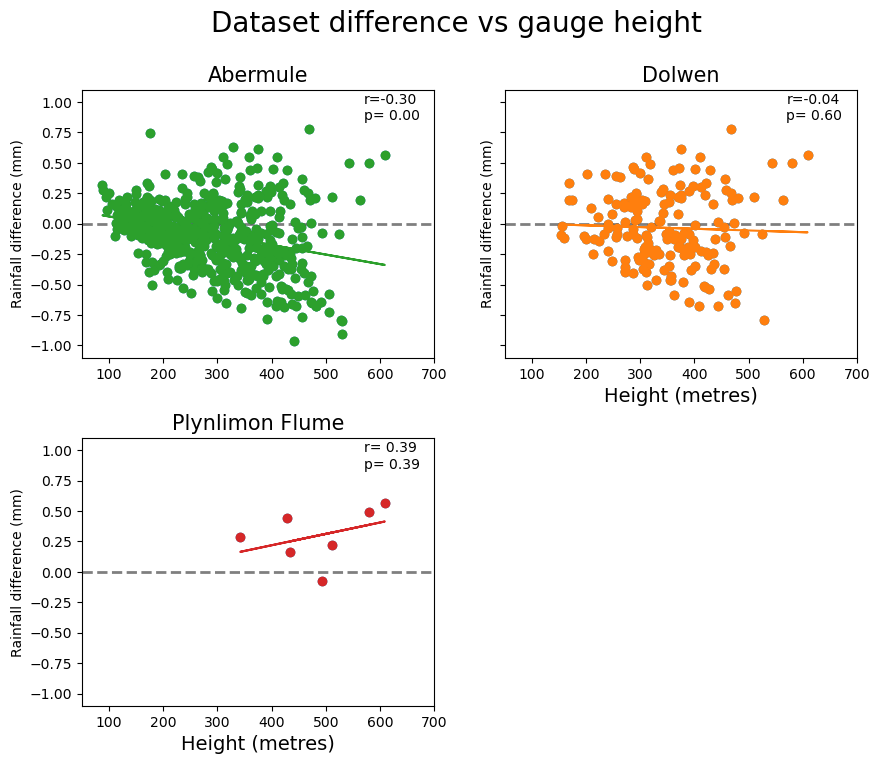

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=False, sharey=True)

for ax, catchment, color_to_use in zip(axes.flatten(), catchments_shp_and_hght.keys(), ['C2', 'C1', 'C3']):
    region_mask_diff_mean = mask_region_rainfall(ceh_haduk_diff_mean, catchments_shp_and_hght[catchment]['hght'])
    x = (region_mask_diff_mean['hght']/10).data.flatten()
    y = region_mask_diff_mean['rain_mm_diff'].data.flatten()
    ## workaround required when using mask
    x = x[np.isfinite(x)]
    y = y[np.isfinite(y)]

    ax.axhline(0, linestyle='--', linewidth=2, color='k', alpha=.5)
    plot_scatter_w_regline(x, y, ax, x_pos=570, y_pos=.85, color=color_to_use)
    # plot_quadrat_count_plot(x, y, ax)
    ax.set_title(f"{catchment}", size=15)
    ax.set_xlabel("Height (metres)", size=14)
    ax.set_ylabel("Rainfall difference (mm)")
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(50, 700)

axes[0][0].set_xlabel('')
axes[1][1].remove()
fig.suptitle("Dataset difference vs gauge height", size=20)
fig.subplots_adjust(hspace=.3)

# fig.savefig('../figures/ceh_vs_haduk_differences/uppersevern_rain_vs_height_scatter.png', bbox_inches='tight', dpi=200)

### ⭐ Intepretation of above figure:
-

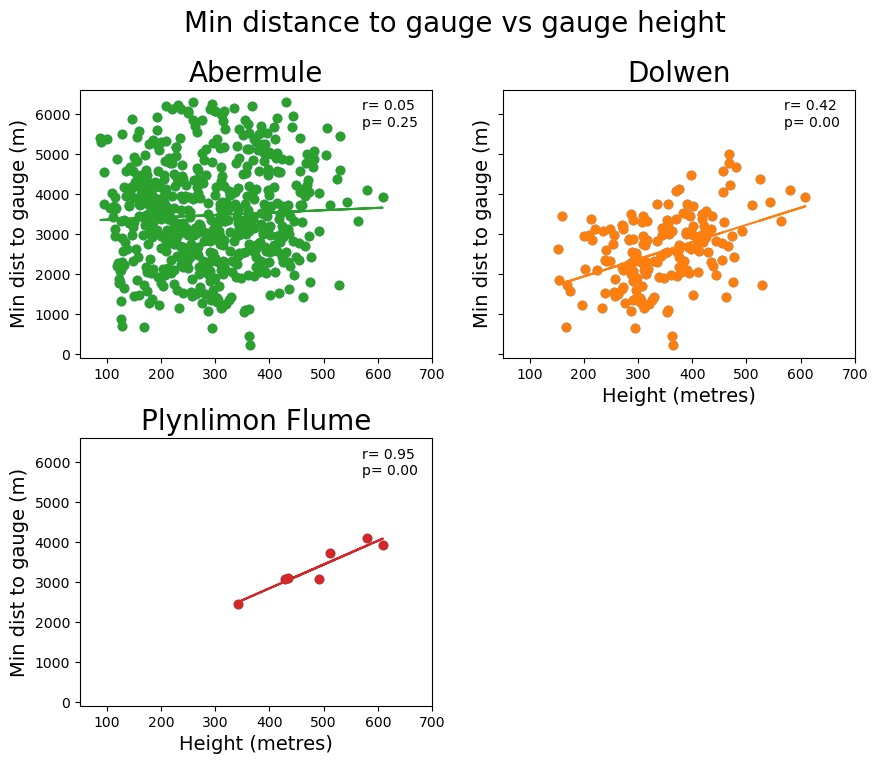

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=False, sharey=True)

for ax, catchment, color_to_use in zip(axes.flatten(), catchments_shp_and_hght.keys(), ['C2', 'C1', 'C3']):
    region_mask_diff_mean = mask_region_rainfall(ceh_haduk_diff_mean, catchments_shp_and_hght[catchment]['hght'])
    x = (region_mask_diff_mean['hght']/10).data.flatten()
    y = region_mask_diff_mean['min_dist'].data.flatten()
    ## workaround required when using mask
    x = x[np.isfinite(x)]
    y = y[np.isfinite(y)]

    plot_scatter_w_regline(x, y, ax, x_pos=570, y_pos=5700, c=color_to_use)
    ax.set_title(f"{catchment}", size=20)
    ax.set_xlabel("Height (metres)", size=14)
    ax.set_ylabel("Min dist to gauge (m)", size=14)
    ax.set_xlim(50, 700)

axes[0][0].set_xlabel('')
axes[1][1].remove()
fig.suptitle("Min distance to gauge vs gauge height", size=20)

fig.subplots_adjust(hspace=.3)
# fig.savefig('../figures/ceh_vs_haduk_differences/uppersevern_height_vs_mindist_scatter.png', bbox_inches='tight', dpi=200)

### ⭐ Intepretation of above figure:
-

In [48]:
print(f'Total of {int((ceh_haduk_diff_mean['rain_mm_diff'] > 0).sum().data)} grid cells where CEH > HadUK\nTotal of {int((ceh_haduk_diff_mean['rain_mm_diff'] < 0).sum().data)} grid cells where CEH < HadUK')

Total of 590 grid cells where CEH > HadUK
Total of 1075 grid cells where CEH < HadUK


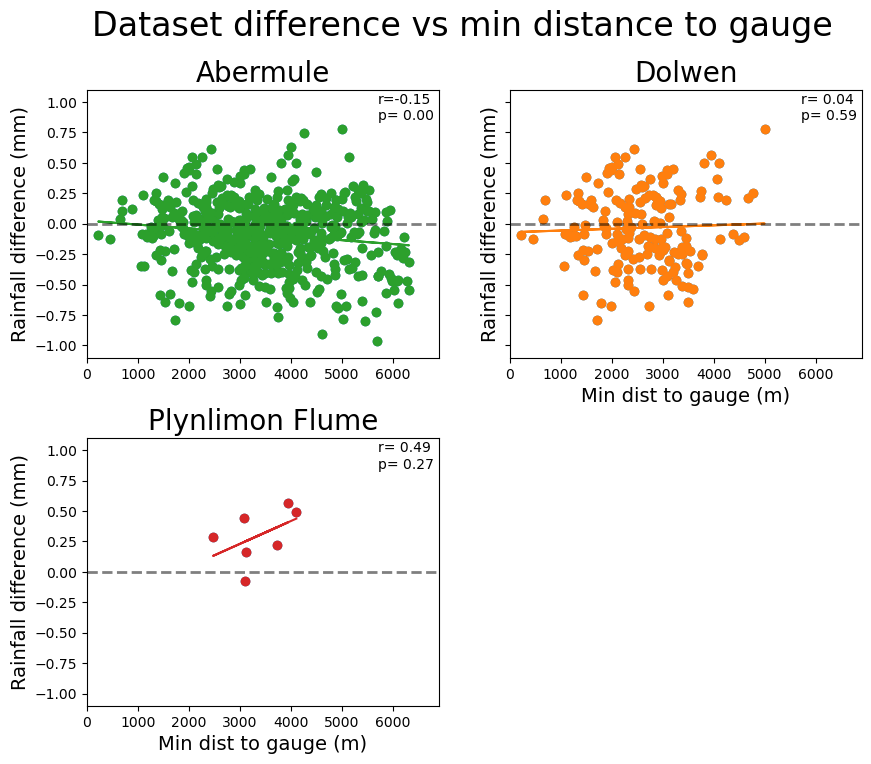

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=False, sharey=True)

for ax, catchment, color_to_use in zip(axes.flatten(), catchments_shp_and_hght.keys(), ['C2', 'C1', 'C3']):
    region_mask_diff_mean = mask_region_rainfall(ceh_haduk_diff_mean, catchments_shp_and_hght[catchment]['hght'])
    x = region_mask_diff_mean['min_dist'].data.flatten()
    y = region_mask_diff_mean['rain_mm_diff'].data.flatten()
    ## workaround required when using mask
    x = x[np.isfinite(x)]
    y = y[np.isfinite(y)]

    plot_scatter_w_regline(x, y, ax, x_pos=5700, y_pos=.85, c=color_to_use)
    ax.axhline(0, linestyle='--', linewidth=2, color='k', alpha=.5)
    ax.set_title(f"{catchment}", size=20)
    ax.set_xlabel("Min dist to gauge (m)", size=14)
    ax.set_ylabel("Rainfall difference (mm)", size=14)
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 6900)
axes[0][0].set_xlabel('')
axes[1][1].remove()
fig.suptitle("Dataset difference vs min distance to gauge", size=24)
fig.subplots_adjust(hspace=.3)

# fig.savefig('../figures/ceh_vs_haduk_differences/uppersevern_rainfall_vs_mindist_scatter.png', bbox_inches='tight', dpi=200)

### ⭐ Intepretation of above figure:
-

Text(0.5, 0.98, 'CEH-GEAR vs HadUK Grid rainfall vs min distance')

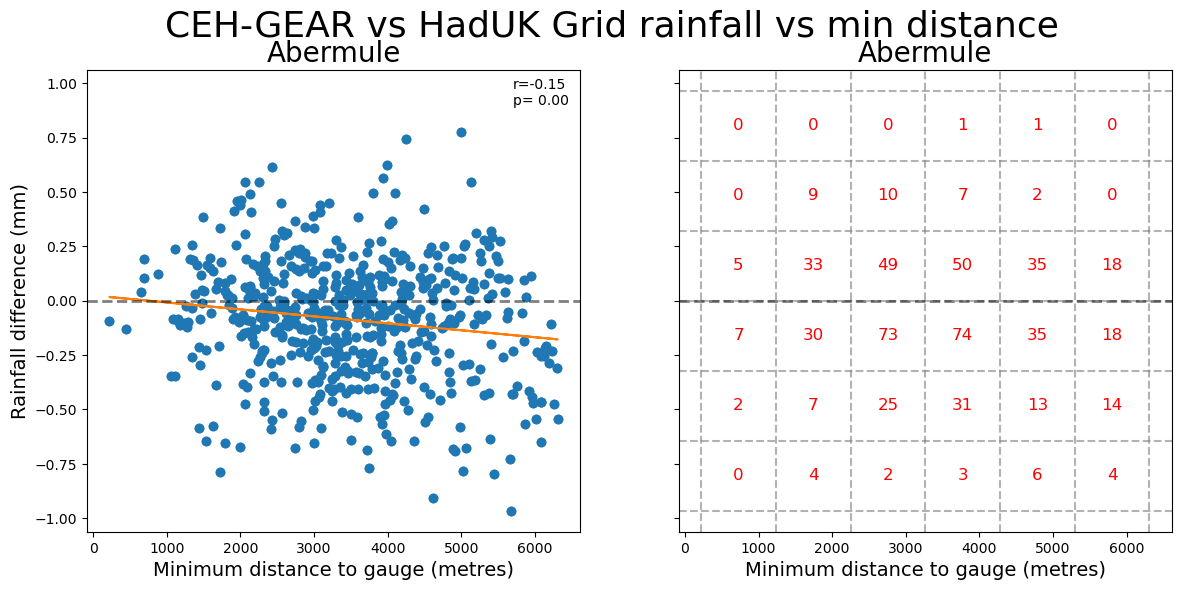

In [50]:
x = region_diff_mean['min_dist'].data.flatten()
y = region_diff_mean['rain_mm_diff'].data.flatten()

## workaround required when using mask
x = x[np.isfinite(x)]
y = y[np.isfinite(y)]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
plot_scatter_w_regline(x, y, axes[0], x_pos=5700, y_pos=.9)
plot_quadrat_count_plot(x, y, axes[1])
for ax in axes:
    ax.set_title(f"{region_to_examine}", size=20)
    ax.set_xlabel("Minimum distance to gauge (metres)", size=14)
    ax.axhline(0, linestyle='--', linewidth=2, color='k', alpha=.5)

axes[0].set_ylabel("Rainfall difference (mm)", size=14)
fig.suptitle("CEH-GEAR vs HadUK Grid rainfall vs min distance", size=26)



### ⭐ Intepretation of above figure:
-

## by season

In [51]:
abermule_mask_seasonal_rainfall = mask_region_rainfall(seasonal_ceh_haduk_diff, abermule_hght)


Text(0.5, 1, 'Abermule: CEH vs HadUK vs Height')

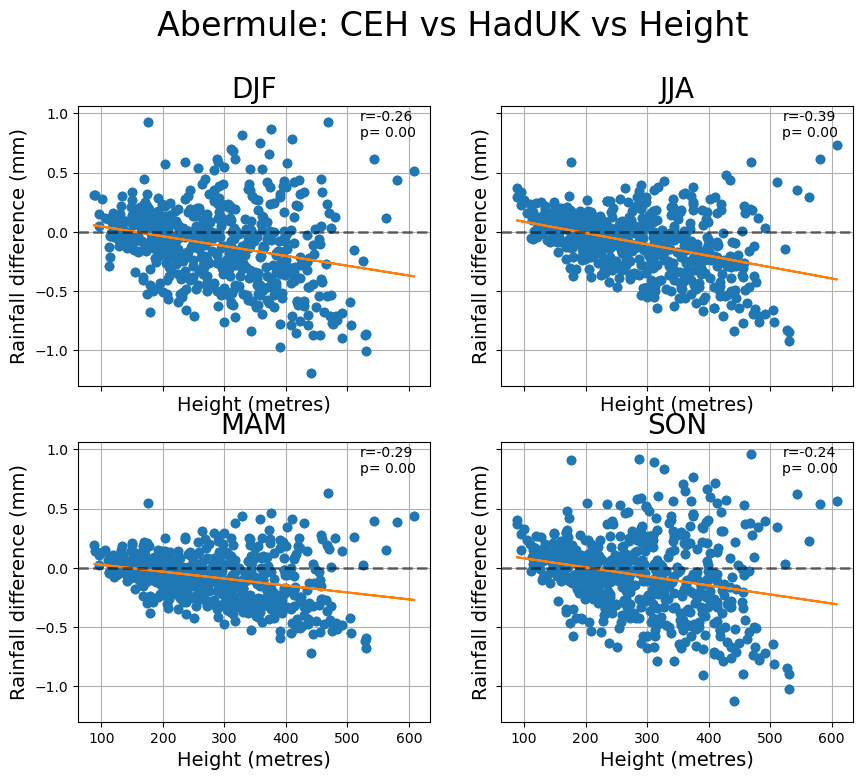

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
for season, ax in zip(abermule_mask_seasonal_rainfall['season'], axes.flatten()):
    x = (abermule_mask_seasonal_rainfall.sel(season=season)['hght']/10).data.flatten()
    y = abermule_mask_seasonal_rainfall.sel(season=season)['rain_mm_diff'].data.flatten()

    ## workaround required when using mask
    x = x[np.isfinite(x)]
    y = y[np.isfinite(y)]

    ax = plot_scatter_w_regline(x, y, ax, x_pos=520, y_pos=.8)
    # plot_quadrat_count_plot(x, y, ax)
    ax.set_title(str(season.data), size=20)
    ax.set_xlabel("Height (metres)", size=14)
    ax.set_ylabel("Rainfall difference (mm)", size=14)
    ax.axhline(0, linestyle='--', linewidth=2, color='k', alpha=.5)
    ax.grid()
fig.suptitle(f'{region_to_examine}: CEH vs HadUK vs Height', size=24, y=1)

### ⭐ Intepretation of above figure:
-

## Plot monthly and daily gauges (extra)

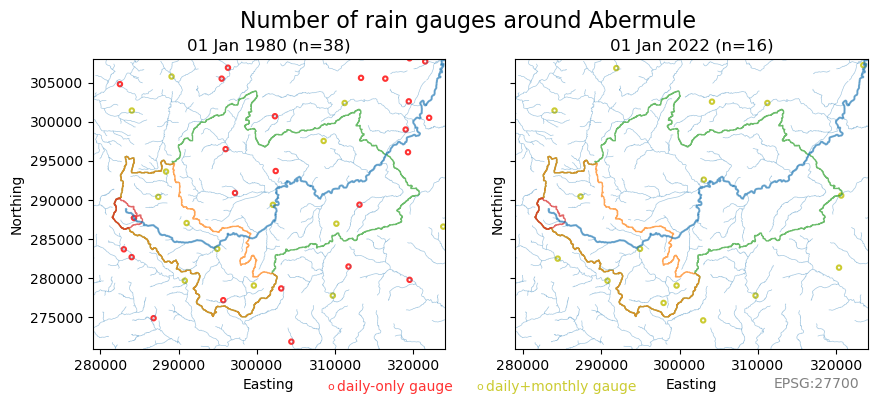

In [53]:
# TEMPORARILY PUT HERE BUT NEED TO MAKE NOTEBOOK OF THIS

def get_gauge_metadata_on_date(date):
    severn_gauges_on_date = severn_all_gauges.filter(pl.col("time") == date)
    plyn_gauge_ids = severn_gauges_on_date['gauge_id'].unique()
    plyn_metadata_on_date = severn_metadata.filter(pl.col("ID").is_in(plyn_gauge_ids))
    return plyn_metadata_on_date

def plot_gauge_scatter(metadata_on_date, ax, **kwargs):
    for row in metadata_on_date.iter_rows(named=True):
        if row['IS_ONLY_DAILY_GAUGE']:
            ax.scatter(row['EASTING'], row['NORTHING'], edgecolor='r', facecolor='None', linewidths=1.5, alpha=.8, **kwargs)
        elif row['IS_ONLY_MONTHLY_GAUGE']:
            ax.scatter(row['EASTING'], row['NORTHING'], edgecolor='g', facecolor='None', linewidths=1.5, alpha=.8, **kwargs)
        else:
            ax.scatter(row['EASTING'], row['NORTHING'], edgecolor='y', facecolor='None', linewidths=1.5, alpha=.8, **kwargs)
    return ax

# Load rivers linestrings
rvs_linestrings = gpd.read_file('../../../Spatial Data/oprvrs_essh_gb/data/WatercourseLink.shp')
rvs_linestrings = rvs_linestrings.dropna(subset=['name1'])
severn_linestrings = rvs_linestrings.loc[rvs_linestrings['name1'].str.contains('River Severn')]

date_to_plot_80s = ceh_severn.sel(time="1980-01-01")['time']
date_to_plot_10s = ceh_severn.sel(time="2022-01-01")['time']

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
abermule_metadata_jan80 = get_gauge_metadata_on_date(date_to_plot_80s)
plot_gauge_scatter(abermule_metadata_jan80, axes[0], s=10)
abermule_metadata_jan10 = get_gauge_metadata_on_date(date_to_plot_10s)
plot_gauge_scatter(abermule_metadata_jan10, axes[1], s=10)
num_abermule_gauges_80s = len(abermule_metadata_jan80.filter((pl.col("EASTING") > min(EASTING_RANGE)) & 
                               (pl.col("EASTING") < max(EASTING_RANGE)) &
                               (pl.col("NORTHING") < max(NORTHING_RANGE)) &
                               (pl.col("NORTHING") > min(NORTHING_RANGE))))

num_abermule_gauges_10s = len(abermule_metadata_jan10.filter((pl.col("EASTING") > min(EASTING_RANGE)) & 
                               (pl.col("EASTING") < max(EASTING_RANGE)) &
                               (pl.col("NORTHING") < max(NORTHING_RANGE)) &
                               (pl.col("NORTHING") > min(NORTHING_RANGE))))

axes[0].set_title(f"{date_to_plot_80s.dt.strftime("%d %b %Y").data} (n={num_abermule_gauges_80s})")
axes[1].set_title(f"{date_to_plot_10s.dt.strftime("%d %b %Y").data} (n={num_abermule_gauges_10s})")
for ax in axes.flatten():
    severn_linestrings.plot(ax=ax, alpha=.6)
    abermule_shp.plot(ax=ax, facecolor='none', edgecolor='C2', linewidth=1, alpha=.7)
    dolwen_shp.plot(ax=ax, facecolor='none', edgecolor='C1', linewidth=1, alpha=.7)
    plynlimon_shp.plot(ax=ax, facecolor='none', edgecolor='C3', linewidth=1, alpha=.7)
    rvs_linestrings.plot(ax=ax, color='C0', linewidth=.5, alpha=.4)
    ax.set_xlabel('Easting', size=10)
    ax.set_ylabel('Northing', size=10)
    ax.set_xlim(EASTING_RANGE)
    ax.set_ylim(NORTHING_RANGE)
ax.text(s="EPSG:27700", x=312000, y=266000, color='grey');
ax.text(s="o", x=255000, y=265700, size=8, color='r', alpha=.8);
ax.text(s="daily-only gauge", x=256200, y=265600, color='r', alpha=.8);
ax.text(s="o", x=274000, y=265700, size=8, color='y', alpha=.8);
ax.text(s="daily+monthly gauge", x=275200, y=265600, color='y', alpha=.8);

plt.suptitle("Number of rain gauges around Abermule", size=16);
# fig.savefig('../figures/num_gauges_around_abermule_1980vs2022.png', bbox_inches='tight', dpi=200)